<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/Project/project-Dog_Breed_CNN_Classification/Dog_Breed_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog_Breed Classification Algorithm for App.

**Previously,** I test two different approachs (1) Transfer learning. and (2) Custom CNN using PyTorch (3 - layer_group, with 10 layers). 

**And now**, I get best accuracy 88% from transfer learing, followed by custom algorithm 63%. So, I decided to use transfer learning. In transfer learning I get beeter accuracy in vgg familly, follwed by densenet, resnet, alexnet. But, the incepton_v3, and resnext * accuracy in true positive and true nagative, both were high. S0, it reflects as weeker algorithm for dog_breed classification. 

**So, here in this notebook** I will use transfer learning, and I will modify last layer according to our custom output. (as we need 1/133 output prediction.)

**AIM:**

In this notebook, finally I will develop algorithm for Do_Breed-Classification Application. We also have human dataset, so I want to use them as prediction task. Just for fun, If a human is detected, it will provide an estimate of the dog breed that is most resembling dog breed. You can use your own photo. :) (In future, I will implement and deploy it,but now I am not sure.) 

Let's Start-

Fist, I will mount my google drive as I use google colaboratory.


Project Idea : My Project Idea is simple

### Do you know the breed of this Dog?

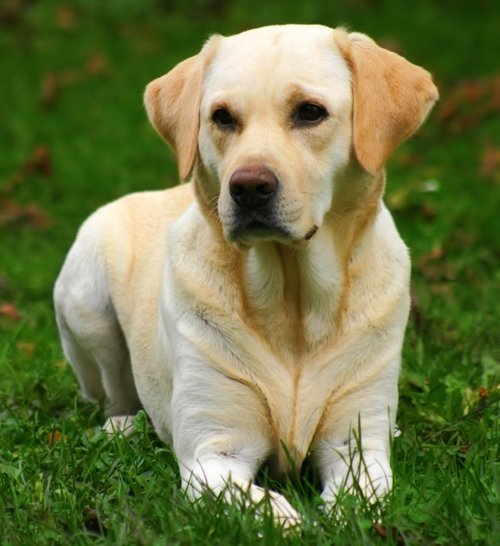

In [3]:
from IPython.display import Image,display 
display(Image('/content/drive/My Drive/proj/images/Labrador_retriever_06457.jpg'))

**I know, its hard to tell,but Neural Network can do it. Let's ask Neural_Net. for this solution.**


---
> Hey, Neurl_Net; Can you say it?


> Neural_Net: 
> Yes, sure for that I will think as follow, and for better understanding, I break the notebook into separate steps. F

**Steps**
1. load, and Trasnfer data
2. Model Architecture
3. Add Loass and Optimizer
4. Train and Validate Model
5. Model Testing
6. Conclusiont for App _ Algorithm. 

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import numpy as np
from glob import glob                                                           # glob is python library used for identifying path according to unix system. It use 

# load filenames for human and dog images
human_files = np.array(glob("/content/drive/My Drive/proj/Data /lfw/*/*"))
dog_files = np.array(glob("/content/drive/My Drive/proj/Data /dogImages/*/*/*"))

human_files_short = human_files[:100]                            # pick first 100 images for testing
dog_files_short = dog_files[:100]                                # pick first 100 images for testing pretrained detector 

Set Requried Parameters (To maintain similarity each time) with train, test, valid dataset.

In [7]:
# set parameters which I usually used during project 
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
img_short_side_resize = 256
img_input_size = 224
shuffle = True
num_workers = 16
batch_size = 64

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `Data/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `Data/lfw`.

> I am using a google drive. You can download data from my drive [setup](https://drive.google.com/drive/folders/1w4YfTwN-WqtFa2eNwj6Mb3Cxwj9HeU_T?usp=sharing) 

---

Please make your own setup, if drive is restricted for you!, Thank you.

Drive 
- proj
-- Data --> DogImages -->Breed Type[i] ---> Dog Image (breed specific)[i]
-- lwf --> Human name[i] --> Human Image[i]
-- Image --> sample Images
-- casecade --> .xml file for face detection.


---
## Data Loader [Access / Load/ Tranfer]


In [8]:
# import required libraries 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                                          # cutting image (specially, short of edge)

import torch
import torchvision.transforms as transforms
from torchvision import datasets 

# define data_transformation and batch_size 
transform_train = transforms.Compose([
                                      transforms.Resize(img_short_side_resize),
                                      transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation =0.2, hue = 0.1),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(img_input_size, scale=(0.08,1), ratio = (1,1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = norm_mean, std = norm_std)
                                       ])

transform_test = transforms.Compose([
                                     transforms.Resize(img_input_size),
                                     transforms.FiveCrop(img_input_size),
                                     transforms.Lambda(lambda crops: torch.stack([
                                                                                  transforms.Compose([
                                                                                                      transforms.ToTensor(),
                                                                                                      transforms.Normalize(mean = norm_mean, std = norm_std)])(crop) for crop in crops
                                                                                  ]))

                                    ])

# load data (define datasets)
train_data = datasets.ImageFolder("/content/drive/My Drive/proj/Data /dogImages/train/",transform_train)
valid_data = datasets.ImageFolder("/content/drive/My Drive/proj/Data /dogImages/valid/",transform_test)
test_data  = datasets.ImageFolder("/content/drive/My Drive/proj/Data /dogImages/test/",transform_test)


# separate imput and labels(classes)
data = {"train" : train_data, "valid" : valid_data, "test" : test_data}
n_classes = len(train_data.classes)

# create loaders (train, valid, test)
train_loader = torch.utils.data.DataLoader(data["train"], batch_size = batch_size, num_workers = num_workers, shuffle = shuffle, pin_memory = True)
valid_loader = torch.utils.data.DataLoader(data["valid"], batch_size = int(np.floor(batch_size/5)), num_workers=0, shuffle = shuffle, pin_memory = True) 
test_loader = torch.utils.data.DataLoader(data["test"], batch_size = int(np.floor(batch_size/5)), num_workers=0, shuffle = shuffle, pin_memory = True)

# loader dictionary
loaders_dict = {"train" : train_loader, "valid" : valid_loader, "test" : test_loader}

## Model Architecture (pretrained Transfer Learning Model) 


In [9]:
import torchvision.models as models 
import torch.nn as nn

# specify model 
model_tl = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


### Adjust parameters 

In [10]:
for param in model_tl.parameters():
    param.requires_grad = False                                                 # pretrained model does not need backpropagation. 

### CUDA checking 

In [11]:
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")
    print("Using",torch.cuda.get_device_name(device))


CUDA is available!  Training on GPU ...
Using Tesla P4


### Model Customization  [Model is already defined]

In [12]:
# modifying last layer as per custome requirements
model_tl.fc = nn.Linear(model_tl.fc.in_features,n_classes)

# initializer the weight for new layers
nn.init.kaiming_normal_(model_tl.fc.weight, nonlinearity = 'relu')

# transfer data and model to CUDA (Tesla P4)
model_tl = model_tl.to(device)

### Specify Loss and Optimizer 

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(model_tl.parameters(),3e-4)
scheduler_tl = ReduceLROnPlateau(optimizer_tl,'min',verbose=True, factor = 0.5, patience =7)

## Train and Validation of Model

---
### Model training and training loss

In [14]:
import time 
def train_epoch(model,train_loader,optimizer,criterion,device):
    train_loss = 0.0
    model.train()                                                               # define training job
    for batch_idx, (data,target) in enumerate(train_loader):                                                                     
        data, target = data.to(device),target.to(device)                        # move to CUDA
        optimizer.zero_grad()                                                   # reset gradient 
        output = model(data)                                                    # run model and get output 
        loss = criterion(output, target)                                        # calculate loss
        train_loss += loss.item() * data.size(0)                                # calculate gradients
        loss.backward()                                                         # update each layer para value
        optimizer.step()
    train_loss = train_loss/len(train_loader.dataset)
    return model, train_loss

### Validation epoch loss 

In [15]:
def valid_epoch(model,valid_loader,criterion,device,fivecrop): 
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)                   # tranfer to CUDA Tesla P 100
            if fivecrop == "mean":
                bs, ncrops, c, h, w = data.size()                               # dimenstion due to 5 crop method              
                output = model(data.view(-1,c,h,w))
                output = output.view(bs, ncrops, -1).mean(1)
            elif fivecrop == "max":
                bs, ncrops, c,h,w = data.size()
                output = model(data.view(-1,c,h,w))
                output = output.view(bs, ncrops, -1).max(1)[0] 
            else:
                output = model(data)
            
            loss = criterion(output, target)                                    # update losses
            valid_loss += loss.item() * data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)
    return valid_loss    

In [16]:
def train(n_epochs, loaders_dict, model,optimizer, criterion, device, path_model, fivecrop = None, lr_scheduler = None):
    valid_loss_min = np.Inf
    train_loss = []
    valid_loss = []
    # time everything 
    time_start = time.time()
    for epoch in range(1, n_epochs+1): 
        time_start_epoch = time.time()
        
        model, train_loss_epoch = train_epoch(model,loaders_dict["train"],optimizer,criterion,device)
        train_loss.append(train_loss_epoch)

        # validate this epoch 
        valid_loss_epoch = valid_epoch(model,loaders_dict["valid"],criterion, device, fivecrop)

        # call learning rate scheduler 
        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss_epoch)
        valid_loss.append(valid_loss_epoch)
        
        # save model for new lowest validation loss 
        if valid_loss_epoch <= valid_loss_min:
            torch.save(model.state_dict(),path_model)
            valid_loss_min = valid_loss_epoch

        print("Epoch {} done in {:.2f} seconds. \t | Training Loss: {:.3f} \t | Validation Loss: {:.3f}".format(
            epoch, time.time() - time_start_epoch, train_loss_epoch, valid_loss_epoch))
    print(f"{n_epochs} epochs ready in {(time.time() - time_start):.3f} seconds. Minimum validation loss: {valid_loss_min:.3f}")
    model.load_state_dict(torch.load(path_model))
    return model


### Model_Training Job Execution

In [16]:
model_tl = train(100, loaders_dict, model_tl, optimizer_tl, criterion_tl, device, 'model_xlearning.pt', fivecrop = 'mean', lr_scheduler = scheduler_tl)  

"""
## NOTE ##
It takes 220 second/epoch on GPU (CUDA)
But, for local gpu one epoch takes around 48 minute

I already run this model previously, on Tesla T4.so just load it. 

"""



Epoch 1 done in 948.50 seconds. 	 | Training Loss: 2.353 	 | Validation Loss: 1.232
Epoch 2 done in 217.04 seconds. 	 | Training Loss: 1.406 	 | Validation Loss: 1.021
Epoch 3 done in 216.65 seconds. 	 | Training Loss: 1.247 	 | Validation Loss: 0.947
Epoch 4 done in 214.21 seconds. 	 | Training Loss: 1.102 	 | Validation Loss: 0.966
Epoch 5 done in 210.54 seconds. 	 | Training Loss: 1.032 	 | Validation Loss: 0.765
Epoch 6 done in 214.91 seconds. 	 | Training Loss: 0.924 	 | Validation Loss: 0.711
Epoch 7 done in 215.74 seconds. 	 | Training Loss: 0.892 	 | Validation Loss: 0.649
Epoch 8 done in 221.40 seconds. 	 | Training Loss: 0.863 	 | Validation Loss: 0.744
Epoch 9 done in 213.33 seconds. 	 | Training Loss: 0.829 	 | Validation Loss: 0.682
Epoch 10 done in 220.05 seconds. 	 | Training Loss: 0.787 	 | Validation Loss: 0.862
Epoch 11 done in 215.14 seconds. 	 | Training Loss: 0.753 	 | Validation Loss: 0.657
Epoch 12 done in 215.50 seconds. 	 | Training Loss: 0.772 	 | Validation L

'\n## NOTE ##\nIt takes 220 second/epoch on GPU (CUDA)\nBut, for local gpu one epoch takes around 48 minute\n\nI already run this model previously, on Tesla T4.so just load it. \n\n'

In [19]:
torch.save(model_tl.state_dict(),"/content/drive/My Drive/proj/Data /model_xferlearning.pt")                   # save model to google drive

In [23]:
model_tl.load_state_dict(torch.load("/content/drive/My Drive/proj/Data /model_xferlearning.pt"))               # load trained model from drive

<All keys matched successfully>

In [24]:
model_tl.eval()                                                                                                 # To observe model state.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Model Testing 

In [25]:
def test(loaders, model, criterion, device):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            data, target = data.to(device), target.to(device)
            bs, ncrops, c, h, w = data.size()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.view(-1, c, h, w)) # fuse batch size and ncrops
            output = output.view(bs, ncrops, -1).mean(1)        
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [26]:
test(loaders_dict, model_tl, criterion_tl,device)

Test Loss: 0.426018


Test Accuracy: 88% (736/836)


### Predictive Model

create pipeline for data prediction
> data -- tranfer -- model prediction -- evaluation score -- output 

In [34]:
# display image form path  # here, colab has different appraoch with cv2.imread(), that only accept image path not from list. 
def show_image_from_path(img_path, title = None):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if title is not None:
        plt.gca().set_title(title)
    plt.show()

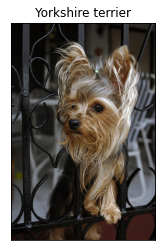

In [110]:
import cv2
import torch.nn.functional as F
class_names = [item[4:].replace("_"," ") for item in data["train"].classes]

def predict_breed_transfer(img_path,model,device):
    # print("in function")
    image = Image.open(img_path).convert("RGB")
    # print("image open")

    in_transform = transforms.Compose([
                                      transforms.Resize(img_short_side_resize),
                                      transforms.FiveCrop(img_input_size),
                                      transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                                                                                                       transforms.ToTensor(),
                                                                                                       transforms.Normalize(mean=norm_mean, std = norm_std)])(crop) for crop in crops]))
                                     ])
    
    scores = model(in_transform(image).to(device)).mean(0)
    output = torch.argmax(scores)  
    return output.to("cpu").item(),  F.softmax(scores,dim=0).to("cpu").data.numpy()

test_image = dog_files_short[0]
pred,probs = predict_breed_transfer(test_image,model_tl, device)
show_image_from_path(test_image,title=class_names[pred])

### Algorithm for Application Prediction.



In [122]:
def pie_visualization(img_path, title_picture, title_pie, likely_pie, likely_probs):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if title_pie is None:
        fig, ax = plt.subplots(figsize=(18,6))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title_picture)
    else:
        fig, ax = plt.subplot(1,2,figsize=(12,5))
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title(title_picture)
        wedges, texts, autotexts = ax[1].pie(likely_probs, autopct = '%1.1f%%', wedgesprops = {'linewidth':0})
        ax[1].axis('equal')
        ax[1].legend(wedges,likely_breeds,title= "likely breeds", 
                     loc = "center left", bbox_to_anchor=(1,0,0.5,1))
        ax[1].set_title(title_pie)
    plt.show()

In [112]:
def process_probs(pred, probs, threshold = 0.01, max_n = 4):
    selection = probs > threshold
    likely_breeds = [breed for (breed, detected) in zip(class_names, selection) if detected]
    likely_probs = [prob for (prob, detected) in zip(probs, selection) if detected]

    order = np.argsort(np.array(likely_probs))[::-1]
    likely_breeds = [likely_breeds[int(i)] for i in order]
    likely_probs = [likely_probs[int(i)] for i in order]
    likely_breeds = likely_breeds[:max_n]
    likely_probs = likely_probs[:max_n]

    # And Let's fill the discarded gap with "other"
    if len(likely_breeds) >1:
        likely_breeds = likely_breeds + ["other"]
        likely_probs = likely_probs + [1-sum(likely_probs)]
    else:
        likely_probs = [100]
    return likely_breeds, likely_probs

In [101]:
def model_predict(img_path,model,device): 
  image = Image.open(img_path).convert('RGB')
  in_transform = transforms.Compose([
                                     transforms.Resize(img_short_side_resize),                                                                                                                   # resize image to standard size (for networks = (224)
                                     transforms.FiveCrop(img_input_size),                                                                                                                        # dk
                                     transforms.Lambda(lambda crops: torch.stack([transforms.Compose([
                                                                                                      transforms.ToTensor(),
                                                                                                      transforms.Normalize(mean=norm_mean, std = norm_std)])(crop) for crop in crops]))])
  output =  torch.argmax(model(in_transform(image).to(device)).mean(0))
  return output.to("cpu").item()

In [102]:
# face detector
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/proj/haarcascades/haarcascade_frontalface_alt.xml')

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0


In [103]:
# dog detector
def dog_detector(img_path, model, device):
    ## TODO: Complete the function.
    out = model_predict(img_path,model,device)
    return out >= 151 and out <= 268 # true/false

In [63]:
alexnet = models.alexnet(pretrained=True)

In [123]:
def run_app(img_path):
  
    deg_detector = dog_detector(img_path, model_dog_detector,device)
    human_detector = face_detector(img_path)
    print("==")
    prediction, probability = predict_breed_transfer(img_path, model_tl,device)
    likely_breed_, likely_prob_ = process_probs(prediction, probability)
    print("--")
    if dog_detector and not human_detector:
        title_picture = print("Dog: Hey Conv, whats my breed?\n", " Conv_Net: You are from ", class_names[pred], " Dog Breed.")
        if len(likely_breed_) == 1:
            title_pie = print("Hey Doggy, you are pure breed!.")
        else:
            title_pie = print("Interesting, you are lucky, you have following breed genes...")
    elif not dog_detector and human_detector:
        title_picture = print("Helllo, there! you are look like ", {class_names[prediction]})
        title_pie = print("Here are all the dog breeds you look like:")
    elif dog_detector and human_detector:
        title_picture = print("Hello Human, you are matched with ", {class_names[prediction]})
        if len(likely_breed_) == 1:
            title_pie = print("You are pure match")
        else:
            title_pie = print("You are matched with mixed breed features")
    else:
        title_picture   = print("That's nice try buddy, but I can not relate it to dog or human")
        title_pie = None
    
    # final result
    pie_visualization(img_path, title_picture, title_pie, likely_breed_, likely_prob_)


==
--
Hello Human, you are matched with  {'Basenji'}
You are matched with mixed breed features


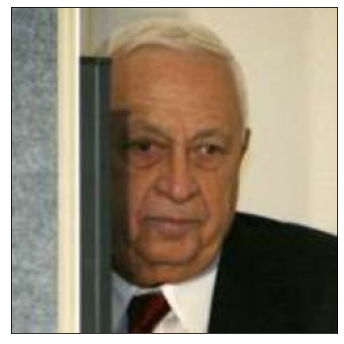

==
--
Hello Human, you are matched with  {'Dogue de bordeaux'}
You are matched with mixed breed features


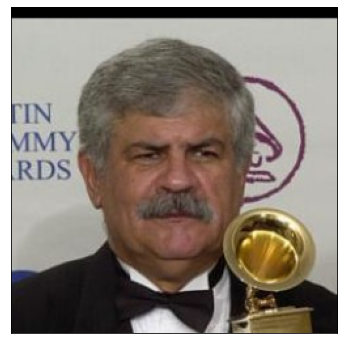

==
--
Hello Human, you are matched with  {'American water spaniel'}
You are matched with mixed breed features


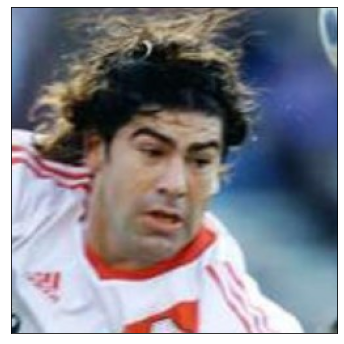

==
--
Hello Human, you are matched with  {'Irish wolfhound'}
You are matched with mixed breed features


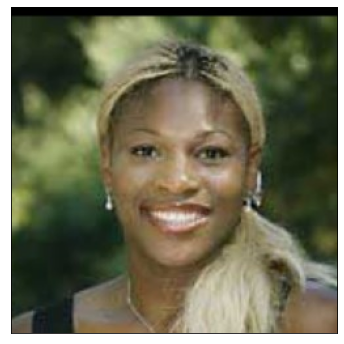

==
--
Hello Human, you are matched with  {'Giant schnauzer'}
You are matched with mixed breed features


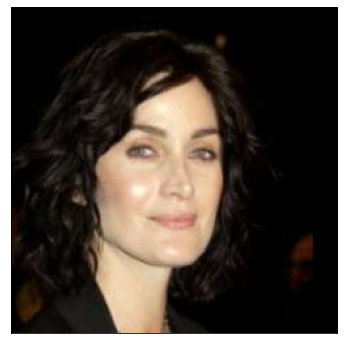

==
--
Dog: Hey Conv, whats my breed?
  Conv_Net: You are from  Yorkshire terrier  Dog Breed.
Interesting, you are lucky, you have following breed genes...


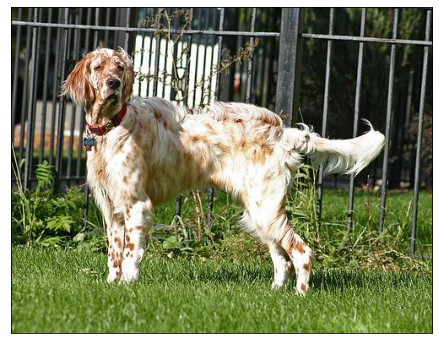

==
--
Dog: Hey Conv, whats my breed?
  Conv_Net: You are from  Yorkshire terrier  Dog Breed.
Hey Doggy, you are pure breed!.


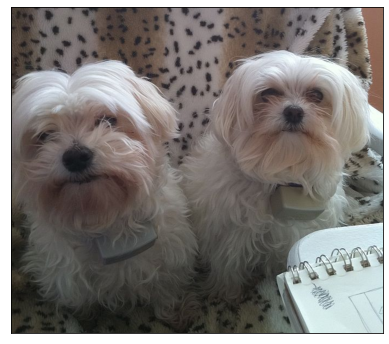

==
--
Dog: Hey Conv, whats my breed?
  Conv_Net: You are from  Yorkshire terrier  Dog Breed.
Hey Doggy, you are pure breed!.


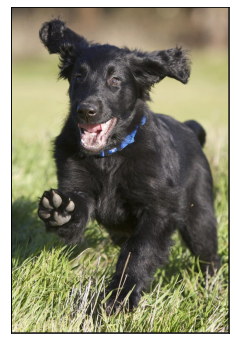

==
--
Dog: Hey Conv, whats my breed?
  Conv_Net: You are from  Yorkshire terrier  Dog Breed.
Hey Doggy, you are pure breed!.


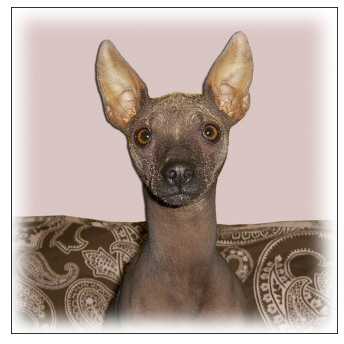

==
--
Dog: Hey Conv, whats my breed?
  Conv_Net: You are from  Yorkshire terrier  Dog Breed.
Hey Doggy, you are pure breed!.


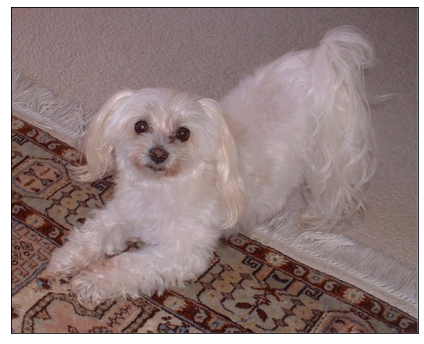

In [124]:
# predict
model_dog_detector = alexnet # Alexnet weirdly turned out to be the best dog detector
model_dog_detector = model_dog_detector.to(device)

## suggested code, below
# Get 10 random images of each type
selection_human = np.random.randint(0,high=len(human_files),size=5)
selection_dogs = np.random.randint(0,high=len(dog_files),size=5)

for file in np.hstack((human_files[selection_human], dog_files[selection_dogs])):
  run_app(file)

In [ ]:
# keep learning, enjoy empowering